In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from synthesize_data_multiclass import synthesize_data
import ER_multiclass as ER

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
def inference(X_train,y_train,X_test,y_test,method='expectation_reflection'):
    if method == 'expectation_reflection':
        h0,w = ER.fit(X_train,y_train,niter_max=100,regu=0.)
        y_pred = ER.predict(X_test,h0,w)

    else:
        if method == 'logistic_regression':
            model = LogisticRegression(multi_class='multinomial',solver='saga')

        if method == 'naive_bayes': 
            model = GaussianNB()

        if method == 'random_forest':
            model = RandomForestClassifier(criterion = "gini", random_state = 1,
                           max_depth=3, min_samples_leaf=5,n_estimators=100)   
            
        if method == 'decision_tree':
            model = DecisionTreeClassifier()  

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
    accuracy = accuracy_score(y_test,y_pred)                
                  
    return accuracy

In [4]:
def compare_inference(X,y,train_size):
    npred = 500
    accuracy = np.zeros((len(list_methods),npred))
    precision = np.zeros((len(list_methods),npred))
    recall = np.zeros((len(list_methods),npred))
    accuracy_train = np.zeros((len(list_methods),npred))
    for ipred in range(npred):
        #X, y = shuffle(X, y)
        X_train0,X_test,y_train0,y_test = train_test_split(X,y,test_size=0.2,random_state = ipred)

        idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y)),replace=False)
        X_train,y_train = X_train0[idx_train],y_train0[idx_train]

        for i,method in enumerate(list_methods):
            accuracy[i,ipred] = inference(X_train,y_train,X_test,y_test,method)
            
    return accuracy.mean(axis=1),accuracy.std(axis=1)

In [5]:
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)
print(X.shape,y.shape)
print(np.unique(y,return_counts=True))

(150, 4) (150,)
(array([0, 1, 2]), array([50, 50, 50]))


In [6]:
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)
X, y = shuffle(X, y)

In [7]:
l,n = X.shape

In [8]:
# create quadratic terms
xij = np.zeros((l,int(n*(n-1)/2)))
k = 0
for i in range(n-1):
    for j in range(i+1,n):        
        xij[:,k] = X[:,i]*X[:,j]
        k += 1

In [9]:
# compile the quadratic terms into X
X = np.hstack([X,xij])

In [10]:
list_train_size = [0.8,0.6,0.4,0.2]
list_methods=['logistic_regression','naive_bayes','random_forest','decision_tree','expectation_reflection']
acc = np.zeros((len(list_train_size),len(list_methods)))
acc_std = np.zeros((len(list_train_size),len(list_methods)))
for i,train_size in enumerate(list_train_size):
    acc[i,:],acc_std[i,:] = compare_inference(X,y,train_size)
    print(train_size,acc[i,:])

0.8 [0.94426667 0.9288     0.9562     0.9558     0.96826667]
0.6 [0.9274     0.9264     0.9526     0.94973333 0.96133333]
0.4 [0.90513333 0.9244     0.948      0.94526667 0.95433333]
0.2 [0.85886667 0.90713333 0.92193333 0.929      0.92546667]


In [11]:
df = pd.DataFrame(acc,columns = list_methods)
df.insert(0, "train_size",list_train_size, True)
df

,train_size,logistic_regression,naive_bayes,random_forest,decision_tree,expectation_reflection
0,0.8,0.944267,0.928800,0.956200,0.955800,0.968267
1,0.6,0.927400,0.926400,0.952600,0.949733,0.961333
2,0.4,0.905133,0.924400,0.948000,0.945267,0.954333
3,0.2,0.858867,0.907133,0.921933,0.929000,0.925467


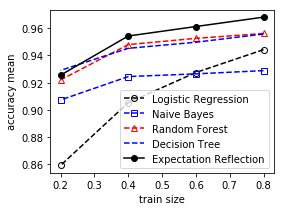

In [12]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc[:,3],'b--',label='Decision Tree')
plt.plot(list_train_size,acc[:,-1],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy mean')
plt.legend()

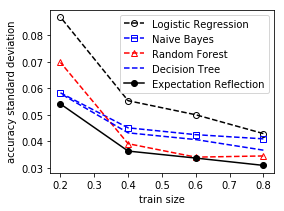

In [13]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc_std[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc_std[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc_std[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc_std[:,3],'b--',label='Decision Tree')
plt.plot(list_train_size,acc_std[:,4],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy standard deviation')
plt.legend()